In [1]:
# import required modules

import matplotlib.pyplot as plt
import numpy as np
import pprint, os

# to get "physion" see: https://github.com/yzerlaut/physion
from physion.analysis.read_NWB import Data
from physion.analysis.process_NWB import EpisodeResponse
from physion.dataviz.show_data import MultimodalData
from physion.assembling.saving import get_files_with_extension

# to get "datavyz" see: https://github.com/yzerlaut/datavyz
from datavyz import graph_env_manuscript as ge

# Dataset

In [2]:
# 
root_datafolder = os.path.join(os.path.expanduser('~'), 'DATA/Fani/CB1-V1-session/')
FILES = np.sort(get_files_with_extension(root_datafolder, '.nwb', recursive=True))

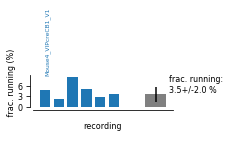

In [3]:
from physion.analysis.behavior import population_analysis
fig, ax = ge.figure(figsize=(1.5,.7), right=5, top=15)
_, ax = population_analysis(FILES, ax=ax)
ge.save_on_desktop(fig, 'fig.png')

# Visualizing raw data

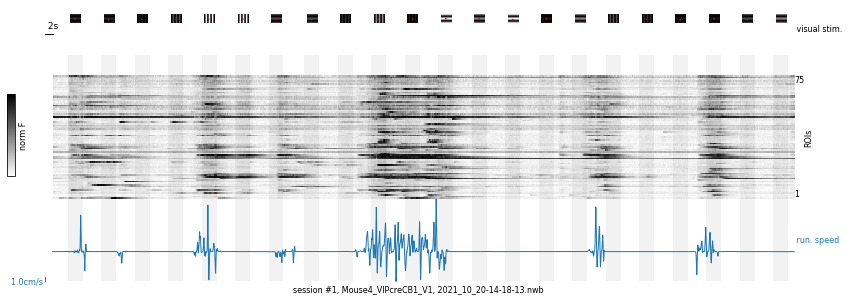

In [4]:
index =0
np.random.seed(10)
data = MultimodalData(FILES[index])
fig, ax = data.plot_raw_data(tlim=[10, 210], 
                  settings={'Locomotion':dict(fig_fraction=2, subsampling=1, color=ge.blue),
                            'CaImagingRaster':dict(fig_fraction=3, subsampling=1,
                                                   roiIndices='all',
                                                   normalization='per-line',
                                                   quantity='CaImaging', subquantity='Fluorescence'),
                            #'CaImaging':dict(fig_fraction=4, subsampling=1,
                            #                       roiIndices=np.sort(np.random.choice(np.arange(data.iscell.sum()),5, 
                            #                                                   replace=False)),
                            #                       quantity='CaImaging', subquantity='Fluorescence'),
                           'VisualStim':dict(fig_fraction=1)},
                   Tbar=2, figsize=(3.5,6));
ge.annotate(ax, 'session #%i, %s, %s ' % (index+1, data.metadata['subject_ID'], FILES[index].split('/')[-1]),
            (0.5,0), ha='center')
# ge.save_on_desktop(fig, 'fig.png', dpi=300)

# Visually-evoked activity - contrast dependency

### Showing example data

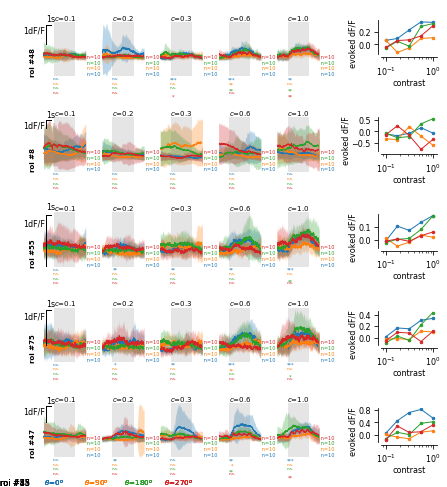

In [29]:
index = 0
FullData = MultimodalData(FILES[index])

CaImaging_options = dict(quantity='CaImaging', subquantity='dF/F')

Nexample = np.min([5, FullData.iscell.sum()])
fig, AX = ge.figure(axes=(5,Nexample), figsize=(.8,1.2), right=13, 
                    bottom=0.3, top=1.5,
                    reshape_axes=False, wspace=0.6, hspace=1.2)

stat_test_props=dict(interval_pre=[-2,0], interval_post=[1,3],
                     test='anova', positive=True)

for n, roiIndex in enumerate(np.random.choice(np.arange(FullData.iscell.sum()), Nexample, replace=False)):

    EPISODES = EpisodeResponse(FullData,
                               protocol_id=0,
                               prestim_duration=-stat_test_props['interval_pre'][0],
                               roiIndex = roiIndex, verbose=False,
                              **CaImaging_options)

    FullData.plot_trial_average(EPISODES=EPISODES,
                                          protocol_id=0,
                                          roiIndex = roiIndex,
                                          color_key='angle',
                                          column_key='contrast',
                                          ybar=1., ybarlabel='1dF/F',
                                          xbar=1., xbarlabel='1s',
                                          fig=fig, AX=[AX[n]], no_set=False,
                                          with_annotation=True,
                                          with_stat_test=True, stat_test_props=stat_test_props,
                                          verbose=False,
                                          **CaImaging_options)

    cell_data = EPISODES.compute_summary_data(stat_test_props,
                                              exclude_keys=['repeat'],
                                              response_significance_threshold=0.05)
    
    inset = ge.inset(fig, (.87,1.-(n+.7)/Nexample,0.13,.35/Nexample))
    
    for a, angle in enumerate(EPISODES.varied_parameters['angle']):
        
        angle_cond = cell_data['angle']==angle
        mResp, sResp = [], []
        
        for c, contrast in enumerate(EPISODES.varied_parameters['contrast']):
            
            cond = angle_cond & (cell_data['contrast']==contrast)
            mResp.append(np.mean(cell_data['value'][cond]))
            sResp.append(np.std(cell_data['value'][cond]))
            
        ge.scatter(EPISODES.varied_parameters['contrast'], mResp, sy=sResp, color=ge.tab10(a), 
                   lw=1, ax=inset, no_set=True)
        
    ge.annotate(AX[n][0], 'roi #%i\n' % (roiIndex+1), (0,0),
                ha='right', rotation=90, size='small', bold=True)
    
    ge.set_plot(inset, xlabel='contrast', xscale='log', ylabel='evoked dF/F     ')
    
#ge.save_on_desktop(fig, 'fig.png', dpi=300)

In [6]:
def get_full_pop_response(filename,
                          protocol_id=0,
                          CaImaging_options = dict(quantity='CaImaging', subquantity='dF/F'),
                          stat_test_props=dict(interval_pre=[-2,0], interval_post=[1,3])):

    FullData = Data(filename)

    EPISODES = EpisodeResponse(FullData,
                               protocol_id=protocol_id,
                               prestim_duration=-stat_test_props['interval_pre'][0],
                               roiIndices = np.arange(FullData.iscell.sum()),
                               verbose=False,
                               **CaImaging_options)

    pop_data = EPISODES.compute_summary_data(stat_test_props,
                                             exclude_keys=['repeat', 'angle'])

    return pop_data['contrast'], pop_data['value'], FullData.iscell.sum(), FullData.metadata['subject_ID']


In [7]:
# 
root_datafolder = os.path.join(os.path.expanduser('~'), 'DATA/Fani/CB1-V1-session/Mouse4/')

CTRL = {'files':np.sort(get_files_with_extension(root_datafolder+'ctrl', '.nwb', recursive=True))}
RIM = {'files':np.sort(get_files_with_extension(root_datafolder+'rimonobant', '.nwb', recursive=True))}
VEH = {'files':np.sort(get_files_with_extension(root_datafolder+'vehicle', '.nwb', recursive=True))}

In [8]:
# compute full pop. resp. curve for all
for cond in [CTRL, RIM, VEH]:
    for key in ['contrasts','curves', 'ncells', 'subject']:
        cond[key] = []
    for f in cond['files']:
        for key, val in zip(['contrasts','curves', 'ncells', 'subject'], get_full_pop_response(f)):
            cond[key].append(val)
    for key in ['contrasts','curves', 'ncells', 'subject']:
        cond[key] = np.array(cond[key])

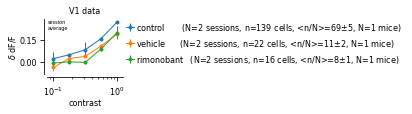

In [13]:
fig, ax = ge.figure(figsize=(1.1,1.2), right=25)
for i, label, cond in zip(range(3), ['control    ', 'vehicle   ', 'rimonobant'], [CTRL, RIM, VEH]):
    ncells = 0
    ge.scatter(cond['contrasts'][0], cond['curves'].mean(axis=0), sy=cond['curves'].std(axis=0), 
               label='%s   (N=%i sessions, n=%i cells, <n/N>=%i$\pm$%i, N=%i mice)' % (label, cond['curves'].shape[0], 
                np.sum(cond['ncells']), np.mean(cond['ncells']), np.std(cond['ncells']), len(np.unique(cond['subject']))),
               ax=ax, no_set=True, color=ge.tab10(i), ms=3, lw=1) 
ge.legend(ax, loc=(1.,0.1))
ge.annotate(ax, 'session\naverage', (0,1), va='top', size='xx-small')
ge.set_plot(ax, xlabel='contrast', ylabel='$\delta$ dF/F', xscale='log')
ge.title(ax, 'V1 data')
ge.save_on_desktop(fig, 'fig.png', dpi=300)

0.0
0.0
0.0


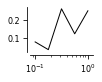

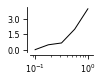

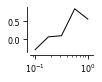

In [7]:
FullData = Data(FILES[index])

#CaImaging_options = dict(quantity='CaImaging', subquantity='d(F-0.7*Fneu)')
CaImaging_options = dict(quantity='CaImaging', subquantity='dF/F')

stat_test_props=dict(interval_pre=[-2,0], interval_post=[1,3],
                     test='ttest', positive=True)


def find_maximal_and_significant_response(cell_data):
    isorted = np.argsort(cell_data['value'])[::-1]
    imax, i = None, 0
    while (imax is None) and i<len(isorted):
        if cell_data['significant'][isorted[i]]:
            imax=isorted[i]
        i+=1
    return imax

for roiIndex in np.arange(FullData.iscell.sum())[:5]:

    EPISODES = EpisodeResponse(FullData,
                               protocol_id=0,
                               prestim_duration=-stat_test_props['interval_pre'][0],
                               roiIndex = roiIndex, verbose=False,
                               **CaImaging_options)
    
    
    cell_data = EPISODES.compute_summary_data(stat_test_props,
                                              exclude_keys=['repeat'],
                                              response_significance_threshold=0.01)
    

    imax = find_maximal_and_significant_response(cell_data)
    
    if imax is not None:
        angle_max = cell_data['angle'][imax]
        angle_cond = cell_data['angle']==angle_max
        print(angle_max)
        ge.plot(cell_data['contrast'][angle_cond], cell_data['value'][angle_cond], axes_args={'xscale':'log'})

In [35]:


def find_maximal_and_significant_response(cell_data):
    isorted = np.argsort(cell_data['value'])[::-1]
    imax, i = None, 0
    while (imax is None) and i<len(isorted):
        if cell_data['significant'][isorted[i]]:
            imax=isorted[i]
        i+=1
    return imax

#print(cell_data['value'][isorted])
#print(cell_data['contrast'][isorted])
#sorted_and_significant_indices = np.arange(len(isorted))[cell_data['significant'][isorted]]
#imax = isorted[sorted_and_significant_indices[-1]]
print(cell_data['significant'][imax])
print(cell_data['value'][imax])
print(cell_data['contrast'][imax])


True
0.8547149349184762
0.5623413251903491


In [23]:
index=0
FullData = MultimodalData(FILES[index])
iprotocol=0
verbose=True


CaImaging_options = dict(quantity='CaImaging', subquantity='dF/F')

stat_test_props=dict(interval_pre=[-2,0], interval_post=[1,3],
                     test='ttest', positive=True)

EPISODES = EpisodeResponse(FullData,
                           protocol_id=0,
                           prestim_duration=-stat_test_props['interval_pre'][0],
                           roiIndices = np.arange(FullData.iscell.sum()),
                           **CaImaging_options)



  Number of episodes over the whole recording: 200/200 (with protocol condition)
  building episodes [...]
  -> [ok] episodes ready !


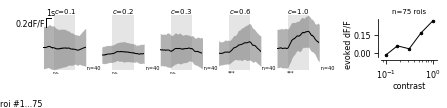

In [25]:
figS, AXs = ge.figure(axes=(5,1), figsize=(.8,1.2), bottom=.7, wspace=0.6, right=13, reshape_axes=False) # summary fig
inset = ge.inset(figS, (.87,0.4,0.13,.35/1))


FullData.plot_trial_average(EPISODES=EPISODES,
                                          protocol_id=iprotocol,
                                          roiIndex = np.arange(FullData.iscell.sum()),
                                          column_key='contrast',
                                          ybar=0.2, ybarlabel='0.2dF/F',
                                          xbar=1., xbarlabel='1s',
                                          fig=figS, AX=AXs, no_set=False,
                                          with_annotation=True,
                                          with_std=True,
                                          with_stat_test=True, stat_test_props=stat_test_props,
                                          verbose=verbose,
                                          **CaImaging_options)

pop_data = EPISODES.compute_summary_data(stat_test_props,
                                         exclude_keys=['repeat', 'angle'],
                                         response_significance_threshold=0.01)

ge.scatter(pop_data['contrast'], pop_data['value'], lw=1, ax=inset, no_set=True)
ge.title(inset, 'n=%i rois' % FullData.iscell.sum(), size='small')
    
ge.set_plot(inset, xlabel='contrast', xscale='log', ylabel='evoked dF/F     ')
    

In [9]:
pop_data = EPISODES.compute_summary_data(stat_test_props,
                                         exclude_keys=['repeat', 'angle'],
                                         response_significance_threshold=0.01)

In [10]:
pop_data

{'value': array([ -3.69046384,  25.49218484,  16.86461151,  63.84288165,
        110.2517601 ]),
 'significant': array([False, False, False,  True,  True]),
 'contrast': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ]),
 'contrast-bins': array([0.06108603, 0.13891397, 0.24702785, 0.43928455, 0.78117066,
        1.21882934])}